In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import random
import math
from scipy.stats import t, ttest_ind, norm, ranksums, spearmanr

In [48]:
sns.set()

In [49]:
def get_preprocessed_df():
  df = pd.read_csv('AMI_GSE66360_series_matrix.csv', encoding='utf-8', skiprows=58, encoding_errors='ignore', index_col=0)
  df = df.drop("ID_REF", axis=0)
  df = df.T
  df.index = [f"{i}" for i in range(1, df.shape[0]+1)]
  return df

In [50]:
df = get_preprocessed_df()
n, m = df.shape
df.head()

<ipython-input-49-9e9407e43743>:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AMI_GSE66360_series_matrix.csv', encoding='utf-8', skiprows=58, encoding_errors='ignore', index_col=0)


,Class,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
1,H,5.866377893,8.22579012,6.17973231,6.179477974,2.792047952,9.290410779,6.998285145,5.348943925,10.742427,...,13.257325,13.266235,14.57123,14.276568,4.504659,3.139334,2.747015,2.651554,3.413429,3.140612
2,H,4.948736331,7.525865369,6.628137025,6.58288903,2.69571445,9.462275035,6.558214949,5.410884095,9.865655308,...,13.59386,13.517013,14.738834,14.341233,4.409226,3.039961,2.638606,2.643615,3.399063,3.132691
3,H,5.148384393,7.764636529,5.859151477,6.602134766,2.580181122,9.116776316,6.851622539,5.254073031,10.148454,...,13.372759,13.416583,14.627181,14.318568,4.310076,3.220109,2.495261,2.626028,3.53997,3.698396
4,H,5.064418945,7.198461482,5.974135101,6.545904723,2.712123845,9.134584186,7.357827486,5.242139865,10.87991277,...,13.490226,13.494827,14.754124,14.363297,4.439311,3.263782,2.544199,2.504958,3.396225,3.638612
5,H,5.017832878,7.831450258,6.793079158,5.911542321,2.723686912,9.582343511,7.283872601,5.219483996,10.09052505,...,13.236785,13.330192,14.548389,14.263677,4.562883,3.138524,2.50663,2.609707,3.43472,3.577649


#**Section 3 - Analysis**


#**a. High level description of the data and some pre-processing**

**1) How many genes profiled?**

54675 genes are profiled in this dataset

**2) How many samples (subjects/patients) in total?**

There are 99 subjects in total

In [51]:
print(f"{m-1} genes are profiled")
print(f"{n} samples were measured")

54675 genes are profiled
99 samples were measured


**3) How many samples in each class?**

**Class H**: 50 samples

**Class H**: 49 samples

In [52]:
class_series = df.iloc[:, 0]
print("Class H samples amount:", len(df[class_series == "H"]))
print("Class M samples amount:", len(df[class_series == "M"]))

Class H samples amount: 50
Class M samples amount: 49


**4) If there are missing values, then remove the entire row
(gene) from the data matrix.**

**How many rows left now?**

After verifying every entry in the dataset, we found that 47 genes had at least 1 missing entry, and therefore they were dropped out.

**Genes left:** 54,628 (54,630 including the 'class' and 'ref' rows)

In [53]:
def clear_missing_columns(df):
  df = df.dropna(axis=1)
  return df

print("Genes amount before cleanups:", n, m - 1)
print("Rows amount before cleanups:", n, m + 1)

df = clear_missing_columns(df)
n, m = df.shape

print("Genes amount after cleanups:", n, m - 1)
print("Rows amount after cleanups:", n, m + 1)

Genes amount before cleanups: 99 54675
Rows amount before cleanups: 99 54677
Genes amount after cleanups: 99 54628
Rows amount after cleanups: 99 54630


**5) Pick 20 genes at random.**

**Draw 20 pair boxplots in one
figure comparing expression levels of each of these genes
in the two classes M and H.**

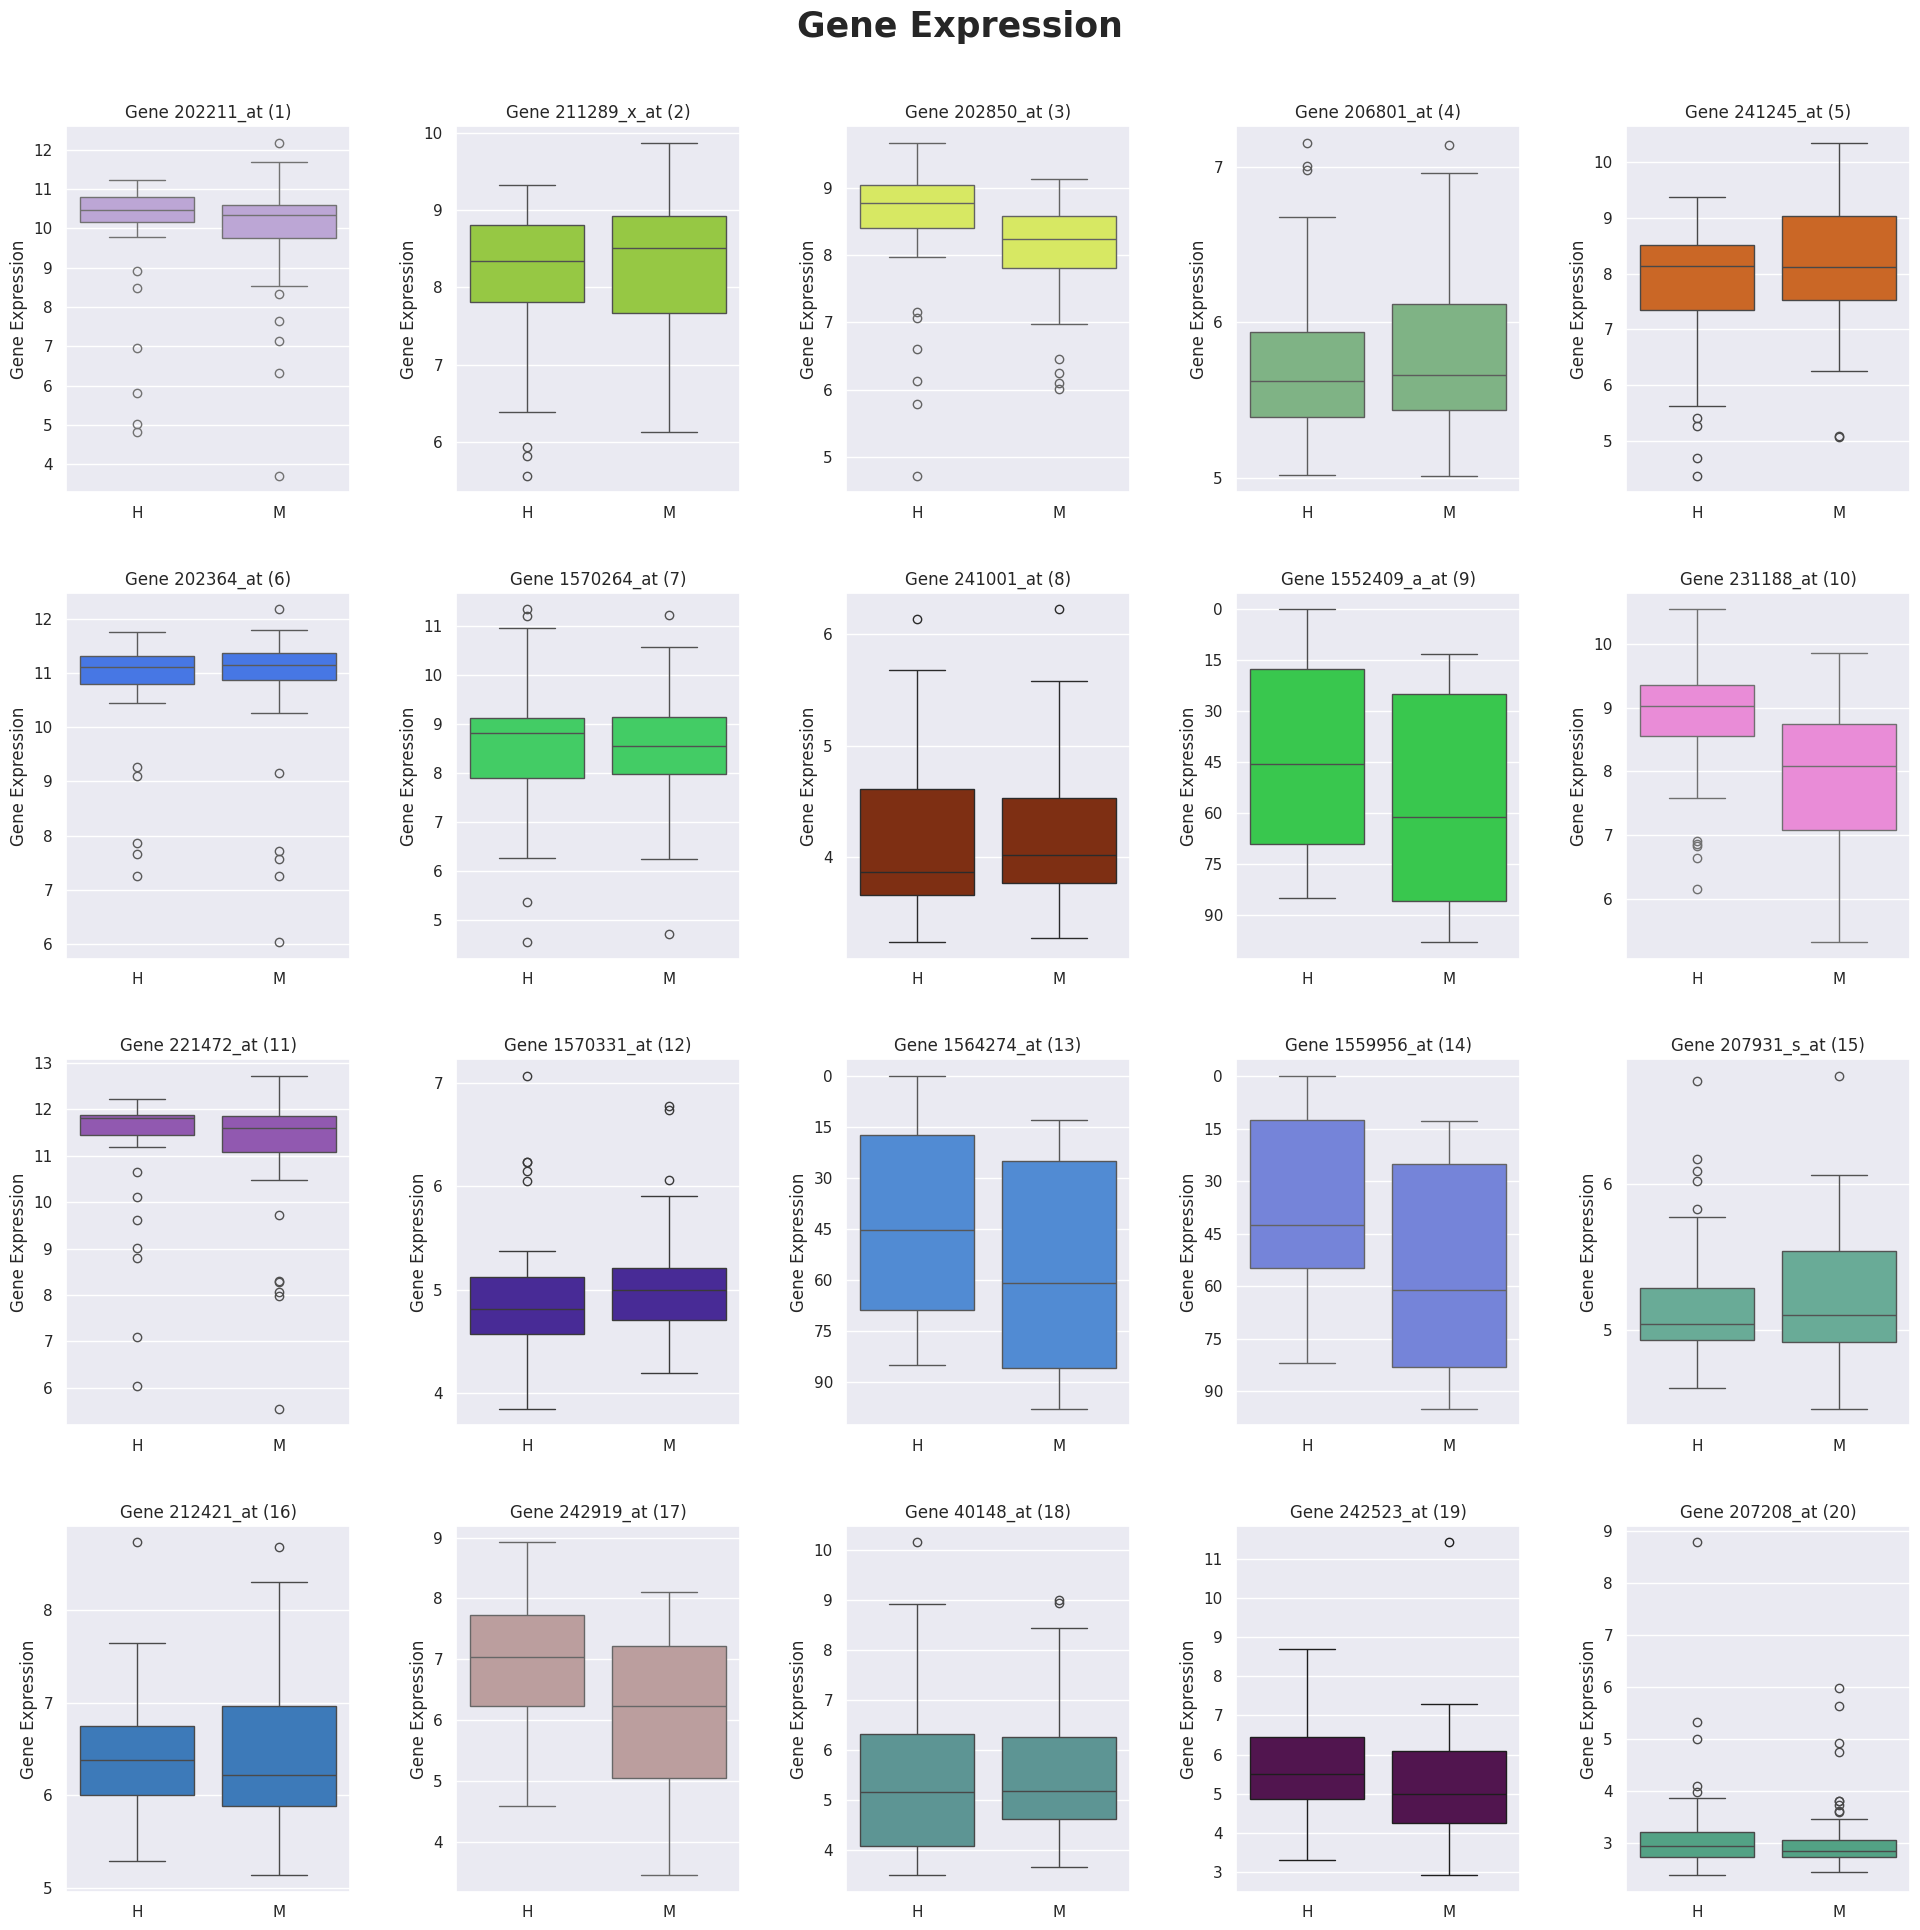

In [54]:
def compare_gene_expression():
  selected_genes_names = np.random.choice(df.columns, 20, replace=False)

  fig, axes = plt.subplots(4, 5, figsize=(20, 20))

  for ax in axes.flat:
      ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Set ticks to be integers
      ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Format ticks as integers

  for i, selected_gene_name in enumerate(selected_genes_names):
    row, column = i//5, i%5
    random_color = np.random.rand(3,)
    boxplot = sns.boxplot(x=df["Class"], y=df[selected_gene_name], data=df, ax=axes[row, column], color=random_color)

    boxplot.set_xlabel("")
    boxplot.set_ylabel("Gene Expression")
    boxplot.set_title(f"Gene {selected_gene_name} ({i + 1})")


  plt.suptitle("Gene Expression", fontsize=25, fontweight='bold')
  plt.subplots_adjust(hspace=0.5)
  plt.tight_layout(pad=3.0)
  plt.show()

compare_gene_expression()

#**b. WRS for differential expression (DE)**

**1) Consider some gene, g. Under the null model (which assumes that
for g there is no M vs H DE), what is the expected sum of ranks of
g’s expression levels measured for samples labeled M?**

**Answer**

The expected sum of ranks measured for samples label 'M' is  $\frac{B⋅(N+1)}{2}= \frac{49⋅99}{2}$ 2450

In [55]:
class_series = df.iloc[:, 0]

B = len(df[class_series == "M"])
expected_ranks_sum = (B * (n + 1)) / 2
std_ranks_sum = np.sqrt((B*(n - B)*(n+1))/12)

print("Expected Sum Of Ranks:", int(expected_ranks_sum))
#print("Expected Std:", std_ranks_sum)

Expected Sum Of Ranks: 2450


In [56]:
class_m_amount = len(df[class_series == "M"])
class_h_amount = len(df[class_series == "H"])

def calc_rank_sum(gene_index):
  gene_name = df.columns[gene_index]

  gene_ranks = df[gene_name].rank()
  gene_ranks_M = gene_ranks[df["Class"] == "M"]
  return gene_ranks_M.sum()

**2) Denote this sum of ranks by RS(g). What is the maximal value, c,
that RS(g) can take?**

**Answer:**
The maximal rank sum value any gene 'g' can take is: 3675

**Explanation:**
This happens when the indices of class 'M' take the highest 49 values.

We calculate the maximal rank sum using an arithmetic progression:

**Where:**

$a_1 = H + 1 = 51$

$a_n = H + M = 99$

$n = M = 49$

$Rank_{max}$ = $\frac{n (a_1 + a_n)}{2} = \frac{49 (51 + 99)}{2} = 3675$



In [57]:
def arithmetic_progression(a_1, a_n, N):
  return N * (a_1 + a_n) / 2

a_1 = class_h_amount + 1
a_n = len(df)

max_rank_sum = arithmetic_progression(a_1, a_n, class_m_amount)
print("max_rank_sum", int(max_rank_sum))

max_rank_sum 3675


**3) Under the null model, what is the probability of RS(g) = c?
(Provide a formula for this and explain it)**

A gene will receive the maximal rank sum if all 'M' entries are ranked higher than 'H' entries.

This is equivalent to choosing k items from a set of n distinct items without regard to the order, i.e. the binomial coefficient

${n \choose k} = \frac{{n!}}{{k! \times (n - k)!}}$

**In our case:**

$n = M + H = 99$

$k = M = 49$

**Conclusion:**

$P[(RS(g) = c] =\frac{1}{n \choose k} = 1.982 ⋅ 10^{-29}$

In [58]:
n_choose_m = math.comb(len(df), class_m_amount)
print(1 / n_choose_m)

1.9823306042836678e-29


**4) Under the null model, what is the probability of RS(g) = c-1?**

**Answer**

**P[RS(g) = c-1 ] = P[max RS(g)] = $\frac{1}{99 \choose 49} = P[(RS(g) = c] = 1.982 ⋅ 10^{-29}$**

Similarly to the last section, this happens when the ranks of 'M' class samples are ranked the highest, and 'H' class samples are ranked the lowest, except for 1 entry.

**Example:**

**Highest rank sum: (= c)**

H H ... H H M M M M ... M

**Second highest rank sum (= c-1):**

 H H ... H  **M** **H** M M M ... M

Since the highest entry of 'H' has to be ranked higher once more than the lowest entry of 'M':
- **(M-1)!**: order M-1 samples of class 'M',
- **(H-1)!**: order H-1 samples of class 'H',
- **M**: choose one of the M samples to be lower than one of the H samples
- **H**: choose one of the H samples to be lower than one of the M samples

$P[(RS(g) = c-1] =\frac{1}{\frac{M(M-1)! ⋅ H(H-1)!}{M+H}}$

$=\frac{1}{M+H \choose M} =\frac{1}{99 \choose 49} = P[(RS(g) = c]$

**Under the null model, what is the probability of RS(g) = c-2?**

P( RS(g) = c-2 ) = $\frac{2}{99 \choose 49}$

This happens when the ranks of 'M' class samples are ranked the highest, and 'H' class samples are ranked the lowest, with few exceptions:

**Case 1:**

The highest 'H' sample is ranked twice higher than the smallest 'M' sample

H H ... H **M M H** M M ... M

- **(M-2)!**: order M-2 samples of class 'M',
- **(H-1)!**: order H-1 samples of class 'H',
- **M ⋅ (M-1)**: choose two of the M samples to be lower than one of the H samples
- **H**: choose one of the H samples to be lower than two of the M samples

**Case 2:**

The two highest 'H' samples are ranked once higher than the smallest 'M' sample

H H ... H **M H H** M M ... M

- **(M-1)!**: order M-1 samples of class 'M',
- **(H-2)!**: order H-2 samples of class 'H',
- **M **: choose one of the M samples to be lower than two of the H samples
- **H ⋅ (H - 1)**: choose two of the H samples to be lower than one of the M samples

$P[(RS(g) = c-2] = \frac{1}{\frac{M(M-1)(M-2)! ⋅ H(H-1)!}{M+H}}  \frac{1}{\frac{M(M-1)! ⋅ H(H-1)(H-2)!}{M+H}}$

$=\frac{2}{M+H \choose M} =\frac{2}{99 \choose 49} = 2 \cdot P[(RS(g) = c] = 3.964 ⋅ 10^{-29}$

In [59]:
print(2 / n_choose_m)

3.9646612085673355e-29


**5) Draw a histogram of the values of RS(g) in the dataset. Here g
ranges over all genes in the data (after the clean-up).**
**Compute the IQR for this distribution and present it on the plot with the histogram.**

In [60]:
rank_sums = {}
for gene_index in range(1, df.shape[1]):
  rank_sum = calc_rank_sum(gene_index)
  rank_sums[gene_index] = rank_sum

Q3 = 2625.0
Q1 = 2297.0
IQR = 328.0


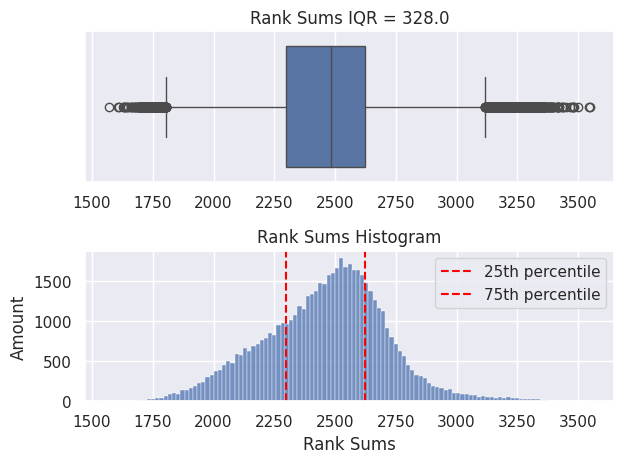

In [61]:
def draw_rank_sums_histogram(rank_sums):
  fig, axes = plt.subplots(2, 1)

  boxplot = sns.boxplot(x=rank_sums, ax=axes[0])
  hist = sns.histplot(rank_sums, ax=axes[1])

  x_25th = np.percentile(rank_sums, 25)
  x_75th = np.percentile(rank_sums, 75)

  print(f"Q3 = {x_75th}")
  print(f"Q1 = {x_25th}")
  print(f"IQR = {x_75th - x_25th}")

  axes[1].axvline(x=x_25th, color='red', linestyle='--', label="25th percentile")
  axes[1].axvline(x=x_75th, color='red', linestyle='--', label="75th percentile")

  axes[0].set_title(f"Rank Sums IQR = {x_75th - x_25th}")

  axes[1].set_title("Rank Sums Histogram")
  axes[1].set_xlabel("Rank Sums")
  axes[1].set_ylabel("Amount")


  plt.legend()
  plt.tight_layout()
  plt.show()

draw_rank_sums_histogram(list(rank_sums.values()))

#**Section 3.c : Differential Expression**

**Differential Gene Expression using WRS test**

In [62]:
pvalue_wrs_over = {}
pvalue_ttest_over = {}

In [63]:
def wrs_test(gene_index):
  gene_name = df.columns[gene_index]
  gene_df = df[["Class", gene_name]]

  gene_Hs = gene_df[gene_df["Class"] == "H"].drop("Class", axis=1).astype(float)
  gene_Ms = gene_df[gene_df["Class"] == "M"].drop("Class", axis=1).astype(float)

  wrs_statistic_less, wrs_pval_less = ranksums(gene_Ms, gene_Hs, alternative="less")
  wrs_statistic_greater, wrs_pval_greater = ranksums(gene_Ms, gene_Hs, alternative="greater")
  return wrs_statistic_less[0], wrs_pval_less[0], wrs_statistic_greater[0], wrs_pval_greater[0]

In [64]:
def calc_wrs_scores():
  significant_de_zscores = {}
  over_expressed_scores_wrs = {}
  under_expressed_scores_wrs = {}

  significant_de_pvals = {}
  over_expressed_scores_pvals = {}
  under_expressed_scores_pvals = {}

  genes_df = df.drop("Class", axis=1)

  for gene in genes_df.columns:
    gene_index = df.columns.get_loc(gene)
    wrs_statistic_less, wrs_pval_less, wrs_statistic_greater, wrs_pval_greater = wrs_test(gene_index)

    pvalue_wrs_over[gene]=wrs_pval_greater

    if wrs_pval_greater <= 0.07:
      significant_de_zscores[gene] = wrs_statistic_greater
      over_expressed_scores_wrs[gene] = wrs_statistic_greater

      significant_de_pvals[gene] = wrs_pval_greater
      over_expressed_scores_pvals[gene] = wrs_pval_greater

    if wrs_pval_less <= 0.07:
      significant_de_zscores[gene] = wrs_statistic_less
      under_expressed_scores_wrs[gene] = wrs_statistic_less

      significant_de_pvals[gene] = wrs_pval_less
      under_expressed_scores_pvals[gene] = wrs_pval_less

  return significant_de_zscores, over_expressed_scores_wrs, under_expressed_scores_wrs, significant_de_pvals, over_expressed_scores_pvals, under_expressed_scores_pvals


In [65]:
significant_de_zscores, over_expressed_wrs_zscores, under_expressed_wrs_zscores, significant_z_pvals, over_expressed_z_pvals, under_expressed_z_pvals = calc_wrs_scores()

In [66]:
print(f'Numbers of over expressed wrs {len(over_expressed_wrs_zscores)}')
print(f'Numbers of under expressed wrs {len(under_expressed_wrs_zscores)}')

Numbers of over expressed wrs 10787
Numbers of under expressed wrs 10667


**Differential Gene Expression using Student's T-test**

In [67]:
def t_test(gene_index):
  gene_name = df.columns[gene_index]
  gene_df = df[["Class", gene_name]]

  gene_Hs = gene_df[gene_df["Class"] == "H"].drop("Class", axis=1).astype(float)
  gene_Ms = gene_df[gene_df["Class"] == "M"].drop("Class", axis=1).astype(float)

  t_statistic_less, t_pval_less = ttest_ind(gene_Ms, gene_Hs, alternative="less")
  t_statistic_greater, t_pval_greater = ttest_ind(gene_Ms, gene_Hs, alternative="greater")

  return t_statistic_less[0], t_pval_less[0], t_statistic_greater[0], t_pval_greater[0]

In [68]:
def calc_t_scores():
  significant_de_tscores = {}
  over_expressed_tscores = {}
  under_expressed_tscores = {}

  significant_de_pvals = {}
  over_expressed_pvals = {}
  under_expressed_pvals = {}

  genes_df = df.drop("Class", axis=1)

  for gene in genes_df.columns:
    gene_index = df.columns.get_loc(gene)
    t_statistic_less, t_pval_less, t_statistic_greater, t_pval_greater = t_test(gene_index)
    pvalue_ttest_over[gene] = t_pval_greater

    if t_pval_greater <= 0.07:
      significant_de_tscores[gene] = t_statistic_greater
      over_expressed_tscores[gene] = t_statistic_greater

      significant_de_pvals[gene] = t_pval_greater
      over_expressed_pvals[gene] = t_pval_greater

    if t_pval_less <= 0.07:
      significant_de_tscores[gene] = t_statistic_less
      under_expressed_tscores[gene] = t_statistic_less

      significant_de_pvals[gene] = t_pval_less
      under_expressed_pvals[gene] = t_pval_less

  return significant_de_tscores, over_expressed_tscores, under_expressed_tscores, significant_de_pvals, over_expressed_pvals, under_expressed_pvals

In [69]:
significant_de_tscores, over_expressed_tscores, under_expressed_tscores, significant_de_pvals, over_expressed_t_pvals, under_expressed_t_pvals = calc_t_scores()

In [70]:
print(f'Numbers of over expressed ttest {len(over_expressed_tscores)}')
print(f'Numbers of under expressed ttest {len(under_expressed_tscores)}')

Numbers of over expressed ttest 8517
Numbers of under expressed ttest 8639


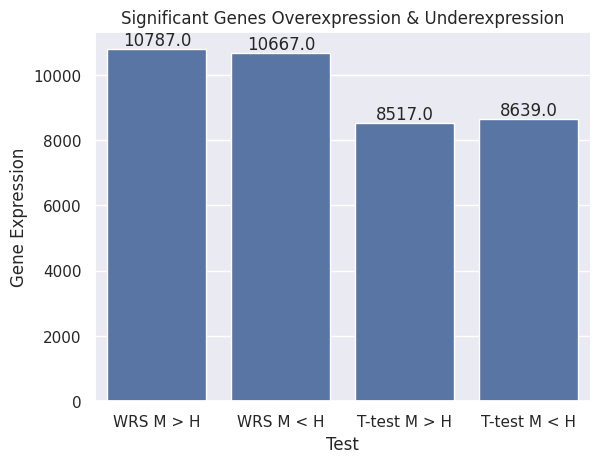

In [71]:
def plot_genes_overexpression_underexpression():
  hypothesis_tests = {
      "Test": ["WRS M > H", "WRS M < H", "T-test M > H", "T-test M < H"],
      "Gene Expression": [len(over_expressed_wrs_zscores), len(under_expressed_wrs_zscores), len(over_expressed_tscores), len(under_expressed_tscores)]  # Sample values for each month
  }

  ax = sns.barplot(x="Test", y="Gene Expression", data=hypothesis_tests)

  for bar in ax.patches:
      ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2),
              ha='center', va='bottom')
  plt.title("Significant Genes Overexpression & Underexpression")

plot_genes_overexpression_underexpression()

#**Section 3.d : Correlations**

**Select the 80 most significant genes from each one of the onesided WRS DE lists you computed in 3c. Generate a set of 160 genes, D, which is the union of the above two sets**


**3.d.1**

Compute Spearman � correlations in all pairs within D (160
choose 2 numbers). Represent the correlation matrix as a 160x160
heatmap.

In [72]:
sorted_keys_over = sorted(over_expressed_wrs_zscores, key=over_expressed_wrs_zscores.get, reverse=True)
top_80_keys_over_expressed = sorted_keys_over[:80]

sorted_keys_under = sorted(under_expressed_wrs_zscores, key=under_expressed_wrs_zscores.get)
top_80_keys_under_expressed = sorted_keys_under[:80]

In [73]:
df_over_80 = df[top_80_keys_over_expressed]
df_under_80 = df[top_80_keys_under_expressed]

D = pd.concat([df_over_80, df_under_80], axis=1)

In [74]:
ranks_160 = D.rank(method='average')

In [75]:
spearman_correlation = np.zeros((160, 160))
for i, gene_name_i in enumerate(ranks_160.columns):
  for j, gene_name_j in enumerate(ranks_160.columns):
    if j > i: continue

    gene_i = list(ranks_160[gene_name_i])
    gene_j = list(ranks_160[gene_name_j])

    spearman_corr, _ = spearmanr(gene_i, gene_j)
    spearman_correlation[i, j] = spearman_corr
    spearman_correlation[j, i] = spearman_corr

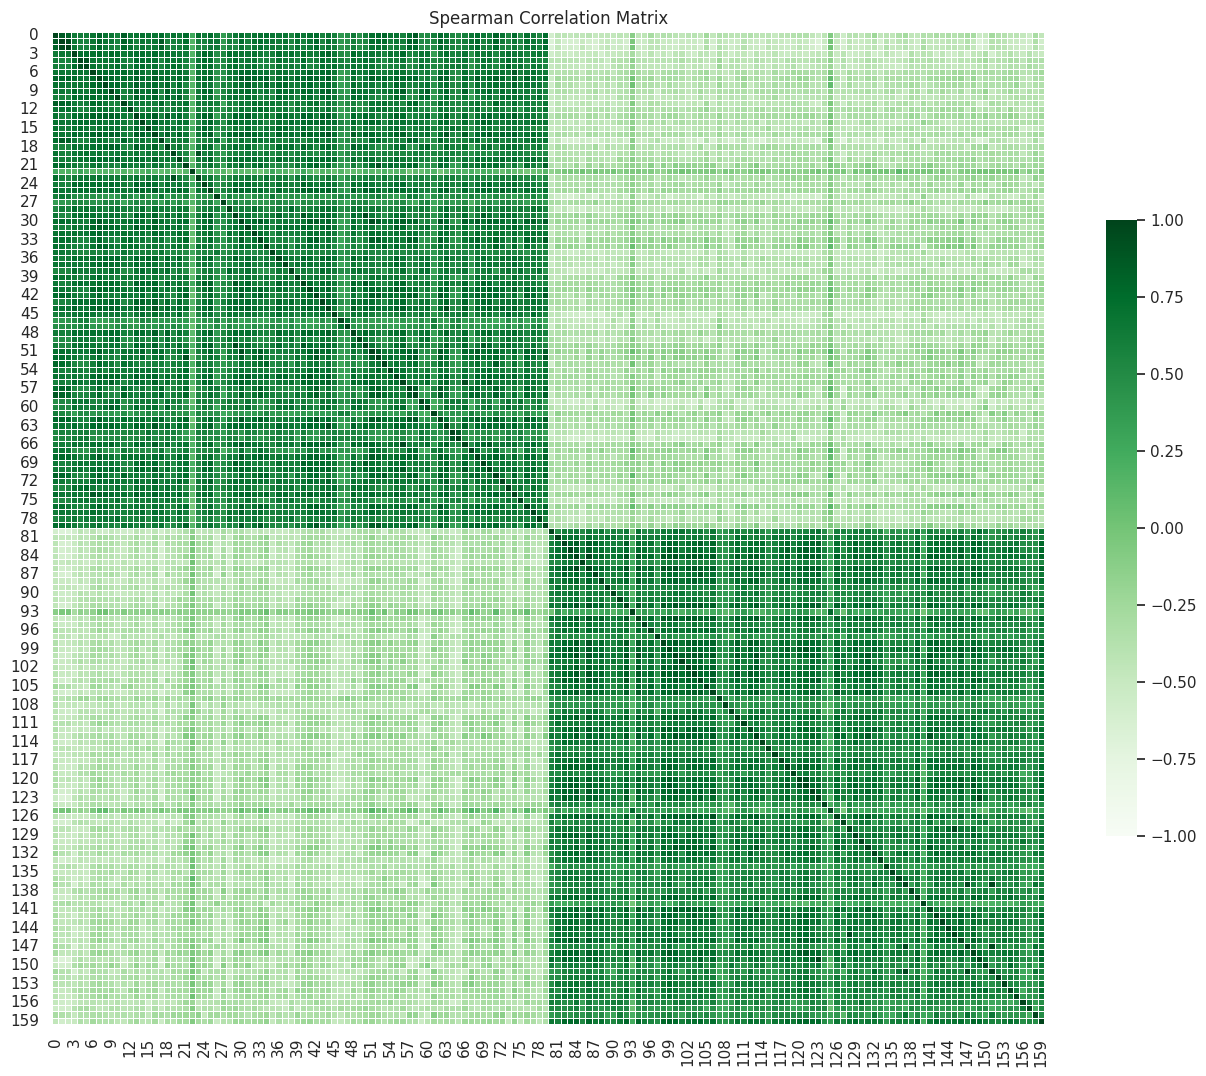

In [76]:
plt.figure(figsize=(16, 16))
sns.heatmap(spearman_correlation, cmap="Greens", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Spearman Correlation Matrix")
plt.show()

**3.d.2.**

**Under a NULL model that assumes that genes are pairwise
independent, what is the expected value for ?**

**Answer 3.d.2**

As learned in class, spearmans' rank coefficient is calculated using the following formula:

$\rho = \frac{Cov(R(Gene_i). R(Gene_j))}{\sigma_{Gene_1} ⋅ \sigma_{Gene_2}}$

So **theoretically**, if $\forall i, j: Gene_i, Gene_j$ are independent

=> $Cov(R(Gene_i). R(Gene_j)) = 0$

=> $\rho=0$

**Empiricaly**, we expect the correlation to have a gaussian distribution with zero mean and a small variance, i.e. small insignificant correlations.


**Conclusion:** under the null model the expected value for spearman's correlation coefficient is 0 theoretically, or a small value around 0 empirically.

**3.d.3**

3.Now compute the Spearman $ρ$ correlations in all 80 choose 2
pairs from the overexpressed genes in D. Present your results
on a histogram. What is the average value you observed?
Compare it to the value in the above section. Explain.


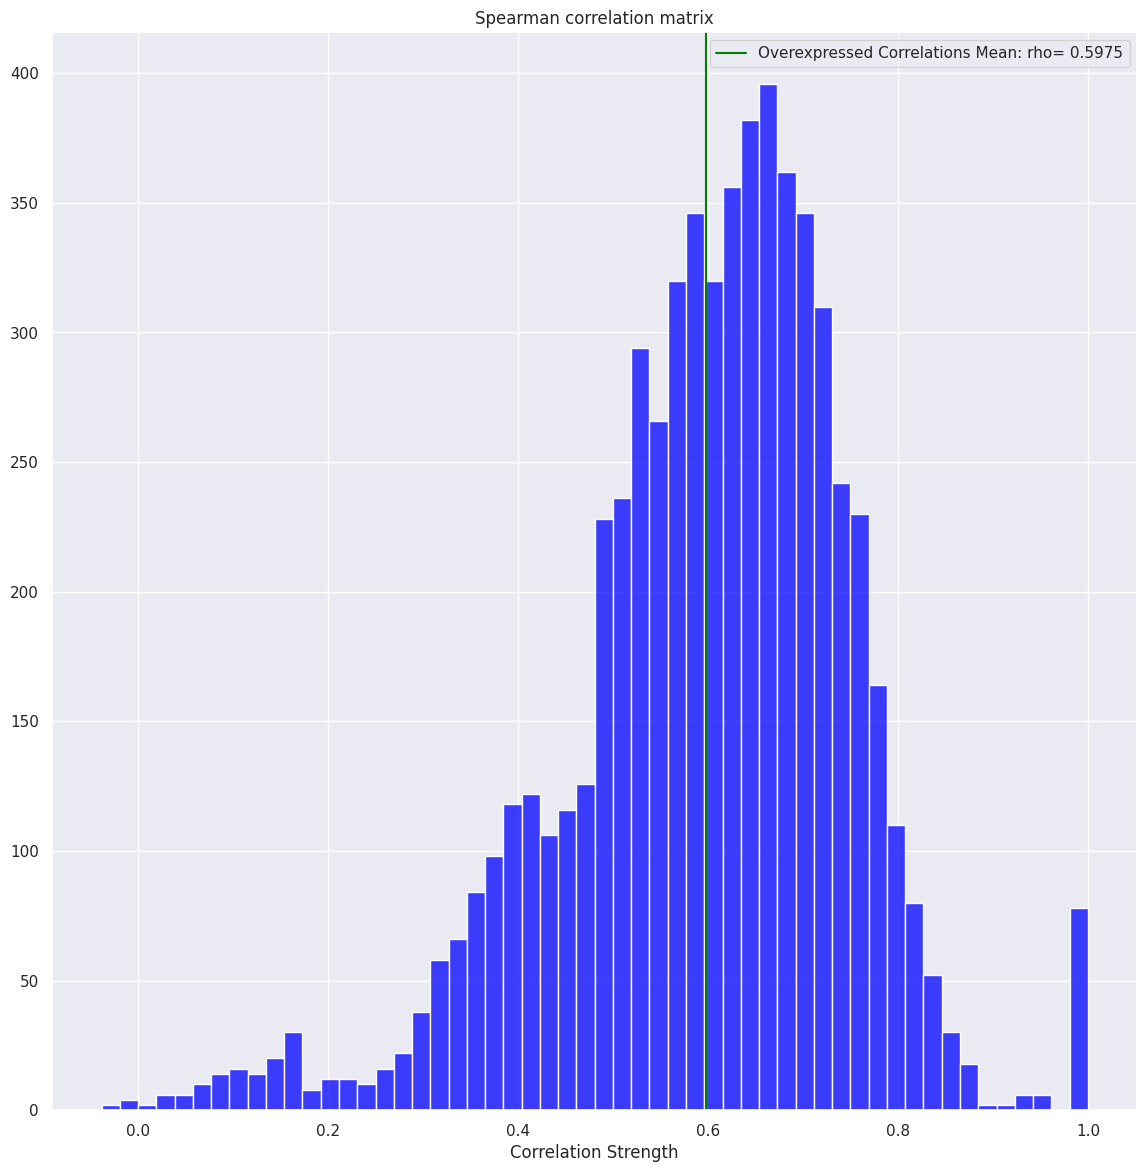

In [93]:
def plot_correlations(ax, n, line_label, color1, color2):
  correlations = spearman_correlation[:n,:n].flatten()
  correlations = [correlation for i, correlation in enumerate(correlations) if i % (n-1) != 0]
  sns.histplot(correlations, color=color2)
  avg = np.mean(correlations)
  avg_rounded = round(avg, 4)
  ax.axvline(avg_rounded, label=f"{line_label} {avg_rounded}", color=color1)
  ax.legend()
  ax.set_xlabel("Correlation Strength")
  ax.set_ylabel("")
  ax.set_title("Spearman correlation matrix")

fig, ax = plt.subplots(figsize=(14, 14))
plot_correlations(ax, 80, "Overexpressed Correlations Mean: rho=", "green", "blue")
plt.show()

**What is the average value you observed? Compare it to the value in the above section. Explain.**

**Answer 3.d.3**
**Overexpressed Correlations Mean:** $ρ=0.5975$
**All Correlations Mean:** $ρ=0.1171$

As observed in the heatmap displayed above:
- the 80 most significant over expressed genes are highly correlated with each other
- the 80 most significant under expressed genes are highly correlated with each other
- Under expressed and over expressed genes are negatively correlated with each other

Therefore, the correlations distribution contains two distributions with high correlation average, and another with low correlation average.

As a result, the average correlation is positive, but relatively low.



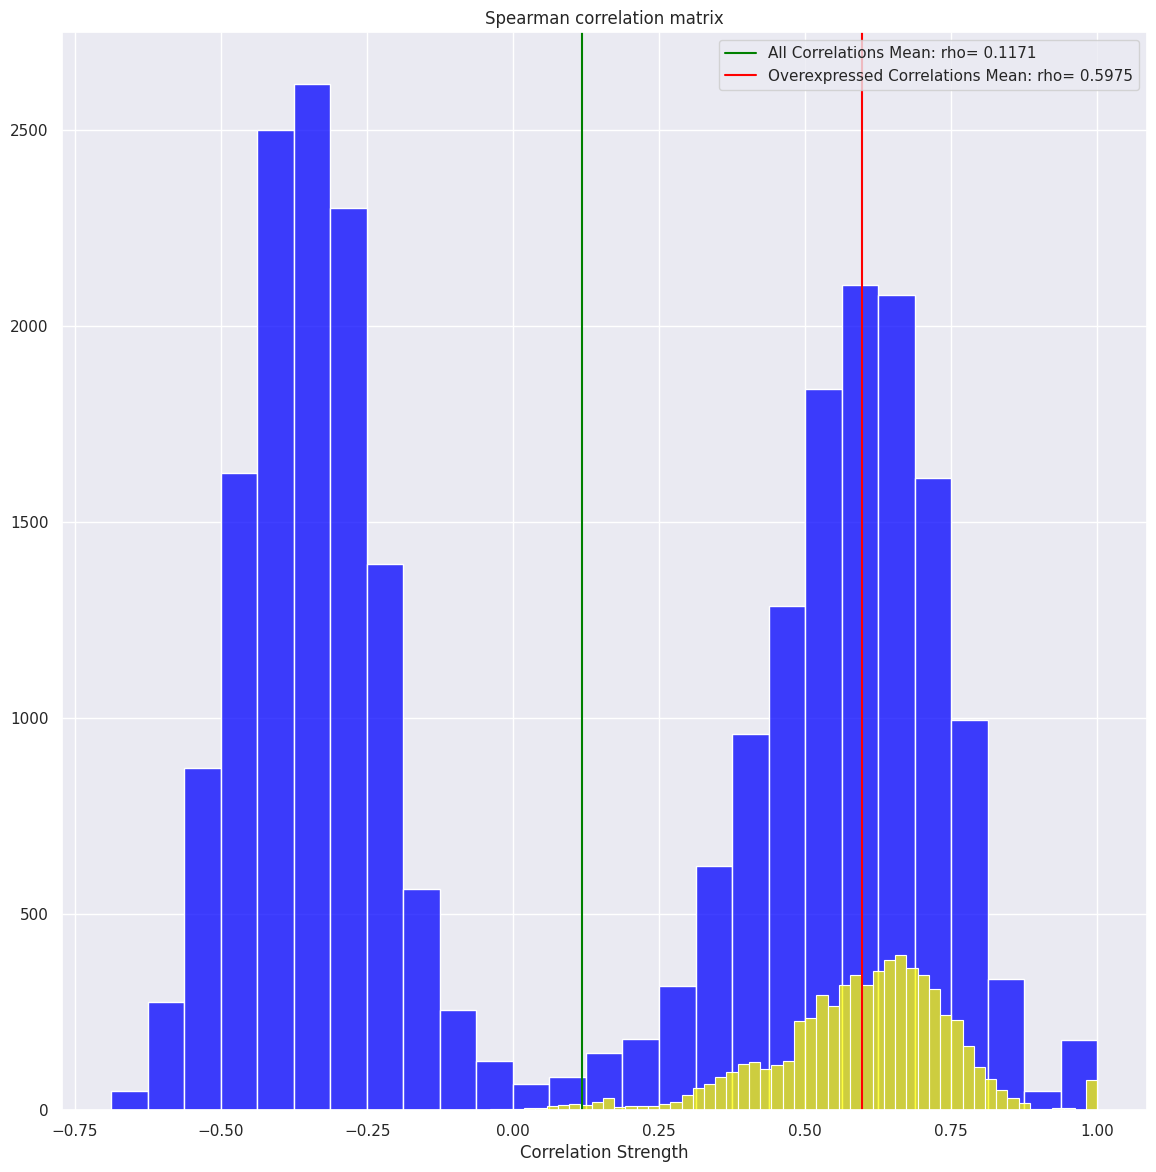

In [94]:
fig, axes = plt.subplots(figsize=(14, 14))

plot_correlations(axes, 160, "All Correlations Mean: rho=", "green", "blue")
plot_correlations(axes, 80, "Overexpressed Correlations Mean: rho=", "red", "yellow")
plt.show()

**3.d.4**

**What can you report about co-expression of genes in D (coexpression is inferred from the correlation of the expression
levels of genes, across a set of samples)?**

Based on the analysis and visualization displayed above, we can report about co expression of genes in D:

- Co-expression among overexpressed genes is high, due to the high correlation between them.
- Co-expression among underexpressed genes is high, due to the high correlation between them
- Co-expression between overexpressed and under expressed genes is low, due to the low correlation between them.

**3.d.5**

**What can you say about how many co-expressed pairs we
would observe (in the entire dataset) at FDR=0.05? Explain
your answer**

**Answer 3.d.5**

We expect to see 1492081878 co-expressed pairs

**Explanation:**

We have M genes in the dataset, therefore there are $\frac{m(m-1)}{2}⋅fdr = \frac{54628(54627)}{2}\cdot0.05$ possible pairs of genes.

Under the null model we expect to see $74604093.9$ genes co-express

In [79]:
M = m - 1
gene_pairs_amount = M * (M - 1) / 2
print(gene_pairs_amount)

1492081878.0


In [80]:
fdr = 0.05
co_expressed_pairs_amount = gene_pairs_amount * fdr
print("Expected genes co-expression amount:", co_expressed_pairs_amount)

Expected genes co-expression amount: 74604093.9


**3.d.6**

**What would have been advantages and disadvantages of
computing co-expression for all genes in the study rather than
only for genes in D?**

**Advantages**:
1. Discover correlations that otherwise would have been missed
2. Discover new patterns - genes with less significant p-values might actually be better correlated with other genes, in comparison to genes with higher pvals.

**Disadvantages**:
1. Multiple Tests: Risk of higher type 1 error (falsly rejecting the null hypothesis) and higher FDR, since much more genes are being tested
2. Computational Complexity - Computing co-expression for all genes is more expensive than computing co-expression only for genes in D


#**Section e. Plots and Conclusions of the DE and correlation analysis**

**3.e.1**

Construct the DE overabundance plots (blue and green lines as shown in class) for M vs H overexpression (M > H) using WRS and t-test using the results you had computed in Section 3c. State, for each comparison, the number of genes, k, at which we observe with an FDR threshold of: a) 𝜏=0.05 b) 𝜏=0.01 c) 𝜏=0.005 If these events are not observed at any k>0, then make that statement.

In [81]:
pvalue_ttest_over = sorted(list(pvalue_ttest_over.values()))
pvalue_wrs_over = sorted(list(pvalue_wrs_over.values()))

In [82]:
def compute_FDR(p_values):
    FDR = np.zeros(len(p_values))
    n = len(p_values)
    for i in range(len(p_values)):
        FDR[i] = p_values[i] * n / (i + 1)
    return FDR

In [83]:
def get_gene_indices(fdrs, thresholds):
  gene_indexs = np.zeros(len(thresholds))
  for index, fdr_threshold in enumerate(thresholds):
    for gene_index,fdr in enumerate(fdrs):
      if fdr > fdr_threshold:
        gene_indexs[index] = gene_index
        break
  return gene_indexs


In [84]:
def plot_FDR(p_values, test_name, ax, thresholds):
  fdrs = compute_FDR(p_values)
  gene_indices = get_gene_indices(fdrs, thresholds)
  ax[0].plot(p_values,np.arange(len(p_values)), color="green", label="Actual")
  ax[0].plot(np.linspace(0, 1.0, len(p_values)), np.arange(len(p_values)), color = "blue", label="Expected")

  sns.barplot(x=thresholds, y=gene_indices, ax=ax[1])
  ax[1].set_xlabel("FDR")
  ax[1].set_ylabel("Genes Amount")
  for bar in ax[1].patches:
    ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(bar.get_height(), 2),
            ha='center', va='bottom')

  ax[0].legend()
  ax[0].set_xlabel("p-val")
  ax[0].set_ylabel("Significant Genes Amount")

  ax[0].set_title("DE Overabundance - " + test_name)
  ax[1].set_title("Genes FDR Amount - " + test_name)

  plt.tight_layout()


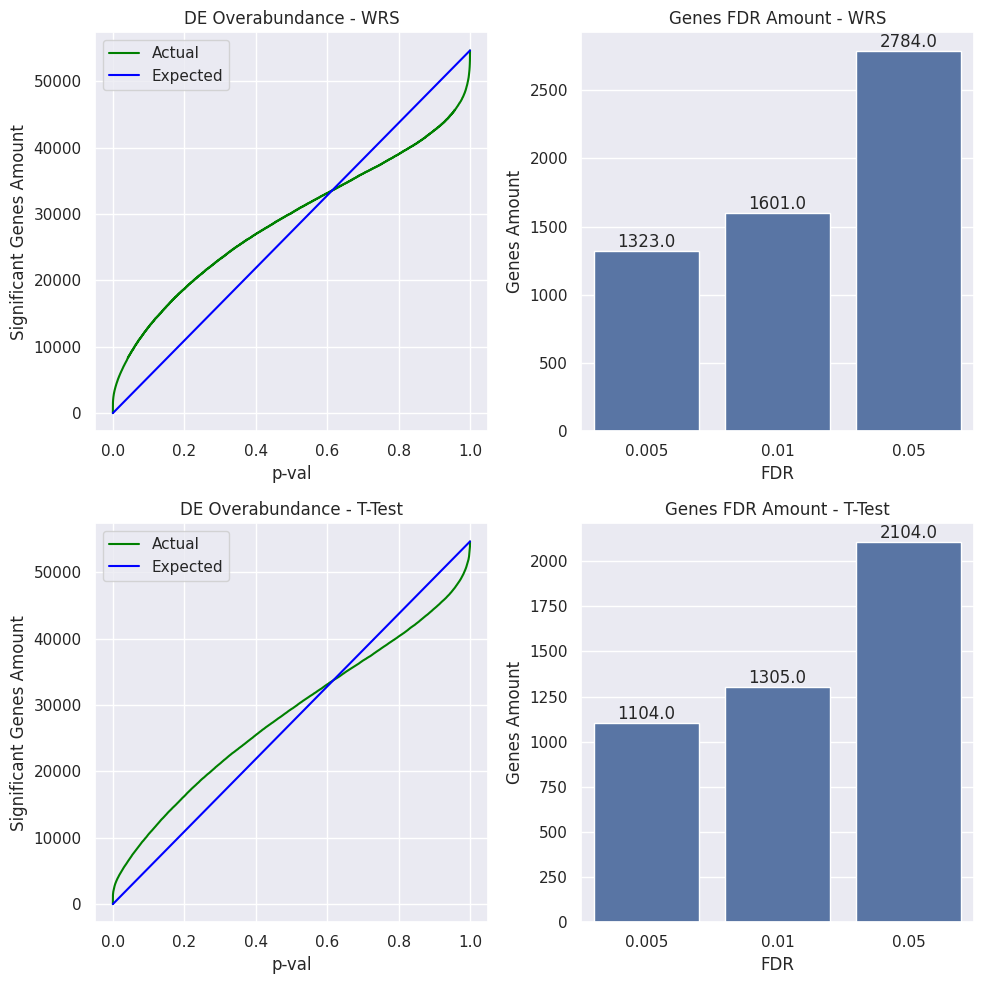

In [85]:
thresholds = [0.05, 0.01, 0.005]
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
plot_FDR(pvalue_wrs_over, "WRS", axis[0], thresholds)
plot_FDR(pvalue_ttest_over, "T-Test", axis[1], thresholds)

**3.e.2**

**For any given gene, g, consider the following set of p-values: 𝑆(𝑔)={𝑝(𝜆)|𝑝(𝜆) 𝑖𝑠 𝑎 𝑊𝑅𝑆 𝑝−𝑣𝑎𝑙𝑢𝑒 𝑓𝑜𝑟 𝑜𝑣𝑒𝑟𝑒𝑥𝑝𝑟𝑒𝑠𝑠𝑖𝑜𝑛 𝑖𝑛 𝑀𝑎𝑓𝑡𝑒𝑟 𝑠𝑤𝑎𝑝𝑝𝑖𝑛𝑔 𝑜𝑛𝑒 𝑙𝑎𝑏𝑒𝑙} (In the above definition 𝜆 represents a label swap – there are 99 such swaps). Let 𝑝𝑈(𝑔)=max𝜆𝑆(𝑔) In words: 𝑝𝑈(𝑔) represents the maximum p-value that could have been obtained for g, assuming a single labeling error. a) For all genes, compute 𝑝𝑈(𝑔). b) Run the FDR procedure with 𝜏=0.05 using 𝑝𝑈(𝑔) (instead of the original p-values as computed in section 3e1a above). How many genes can you report now? c) What is the intersection of the genes you can report above with the results of 3e1a. Explain. Comment: The process you ran in this section yields a set of genes called Robust Differentially Expressed Genes (RDEG).**

**Note**

For efficiency purposes, we calculate the wrs test explicitly

In [86]:
ranks = df.rank(method='average')
ranks["Class"] = df["Class"]

p_U = {}

M_ranks = ranks[ranks["Class"] == 'M']

for index, gene in enumerate(ranks.columns):
  if gene != "Class":
    ranks_sum = calc_rank_sum(index)
    max_rank_M = max(M_ranks[gene])
    p_U[gene] = ranks_sum-max_rank_M

In [87]:
B = len(ranks[ranks["Class"] == 'M']) - 2
expected_ranks_sum = (B * (n + 1)) / 2
std_ranks_sum = np.sqrt((B*(n - B)*(n+1))/12)
gene_to_zscores = {gene: (rank_sum - expected_ranks_sum)/ std_ranks_sum for gene, rank_sum in p_U.items()}

gene_to_pvalue_all_gene = []
for score in gene_to_zscores.values():
  gene_to_pvalue_all_gene.append(norm.sf(score))

#take only the 2791 smallest/largest
sorted_genes = sorted(gene_to_zscores.items(), key=lambda x: x[1], reverse=True)

p_value_p_U = sorted(gene_to_pvalue_all_gene)
thresholds = [0.05]

fdrs = compute_FDR(p_value_p_U)
gene_indices = get_gene_indices(fdrs, thresholds)
print(f"We can report {gene_indices[0]} genes")

We can report 2791.0 genes


In [88]:
threshold = norm.ppf(0.93)
significant_pU_zscores = {gene: score for gene, score in gene_to_zscores.items() if score > threshold}
gene_intersect = np.intersect1d(list(significant_de_zscores.keys()),list(significant_pU_zscores.keys()))
print('The number of genes: ', gene_intersect.shape[0])

The number of genes:  10728


**3.e.3**

**Select any 3 differentially expressed genes, from D (which
was defined in 3d), and produce a graphical representation of
their expression patterns that demonstrates the observed DE**

In [89]:
def plot_3_exression_patterns(D):
  random_indexs = np.random.randint(0,len(D.columns),3)
  D["Class"] = df["Class"]
  genes = []
  genes.append(D[D.columns[random_indexs[0]]])
  genes.append(D[D.columns[random_indexs[1]]])
  genes.append(D[D.columns[random_indexs[2]]])
  fig, axes = plt.subplots(3, 2, figsize=(20, 20))

  for ax in axes.flat:
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Set ticks to be integers
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Format ticks as integers

  for i, gene in enumerate(genes):
    random_color = np.random.rand(3,)
    boxplot = sns.boxplot(x=D["Class"], y=gene, data=D, ax=axes[i, 0], color=random_color)
    boxplot.set_xlabel("")
    boxplot.set_ylabel("Gene Expression")
    boxplot.set_title(f"Gene {D.columns[i]} ({i + 1})")

    axes[i, 1].hist(gene[D["Class"] == "H"], alpha=0.5, label="H")
    axes[i, 1].hist(gene[D["Class"] == "M"], alpha=0.5, label="M")
    axes[i, 1].set_title(" {} expression".format(D.columns[i]))
    axes[i, 1].set_xlabel("Value")
    axes[i, 1].set_ylabel("Count")
    axes[i, 1].legend()

  plt.suptitle("Gene Expression", fontsize=16, fontweight='bold')
  plt.subplots_adjust(hspace=0.5)
  plt.tight_layout(pad=3.0)
  plt.show()



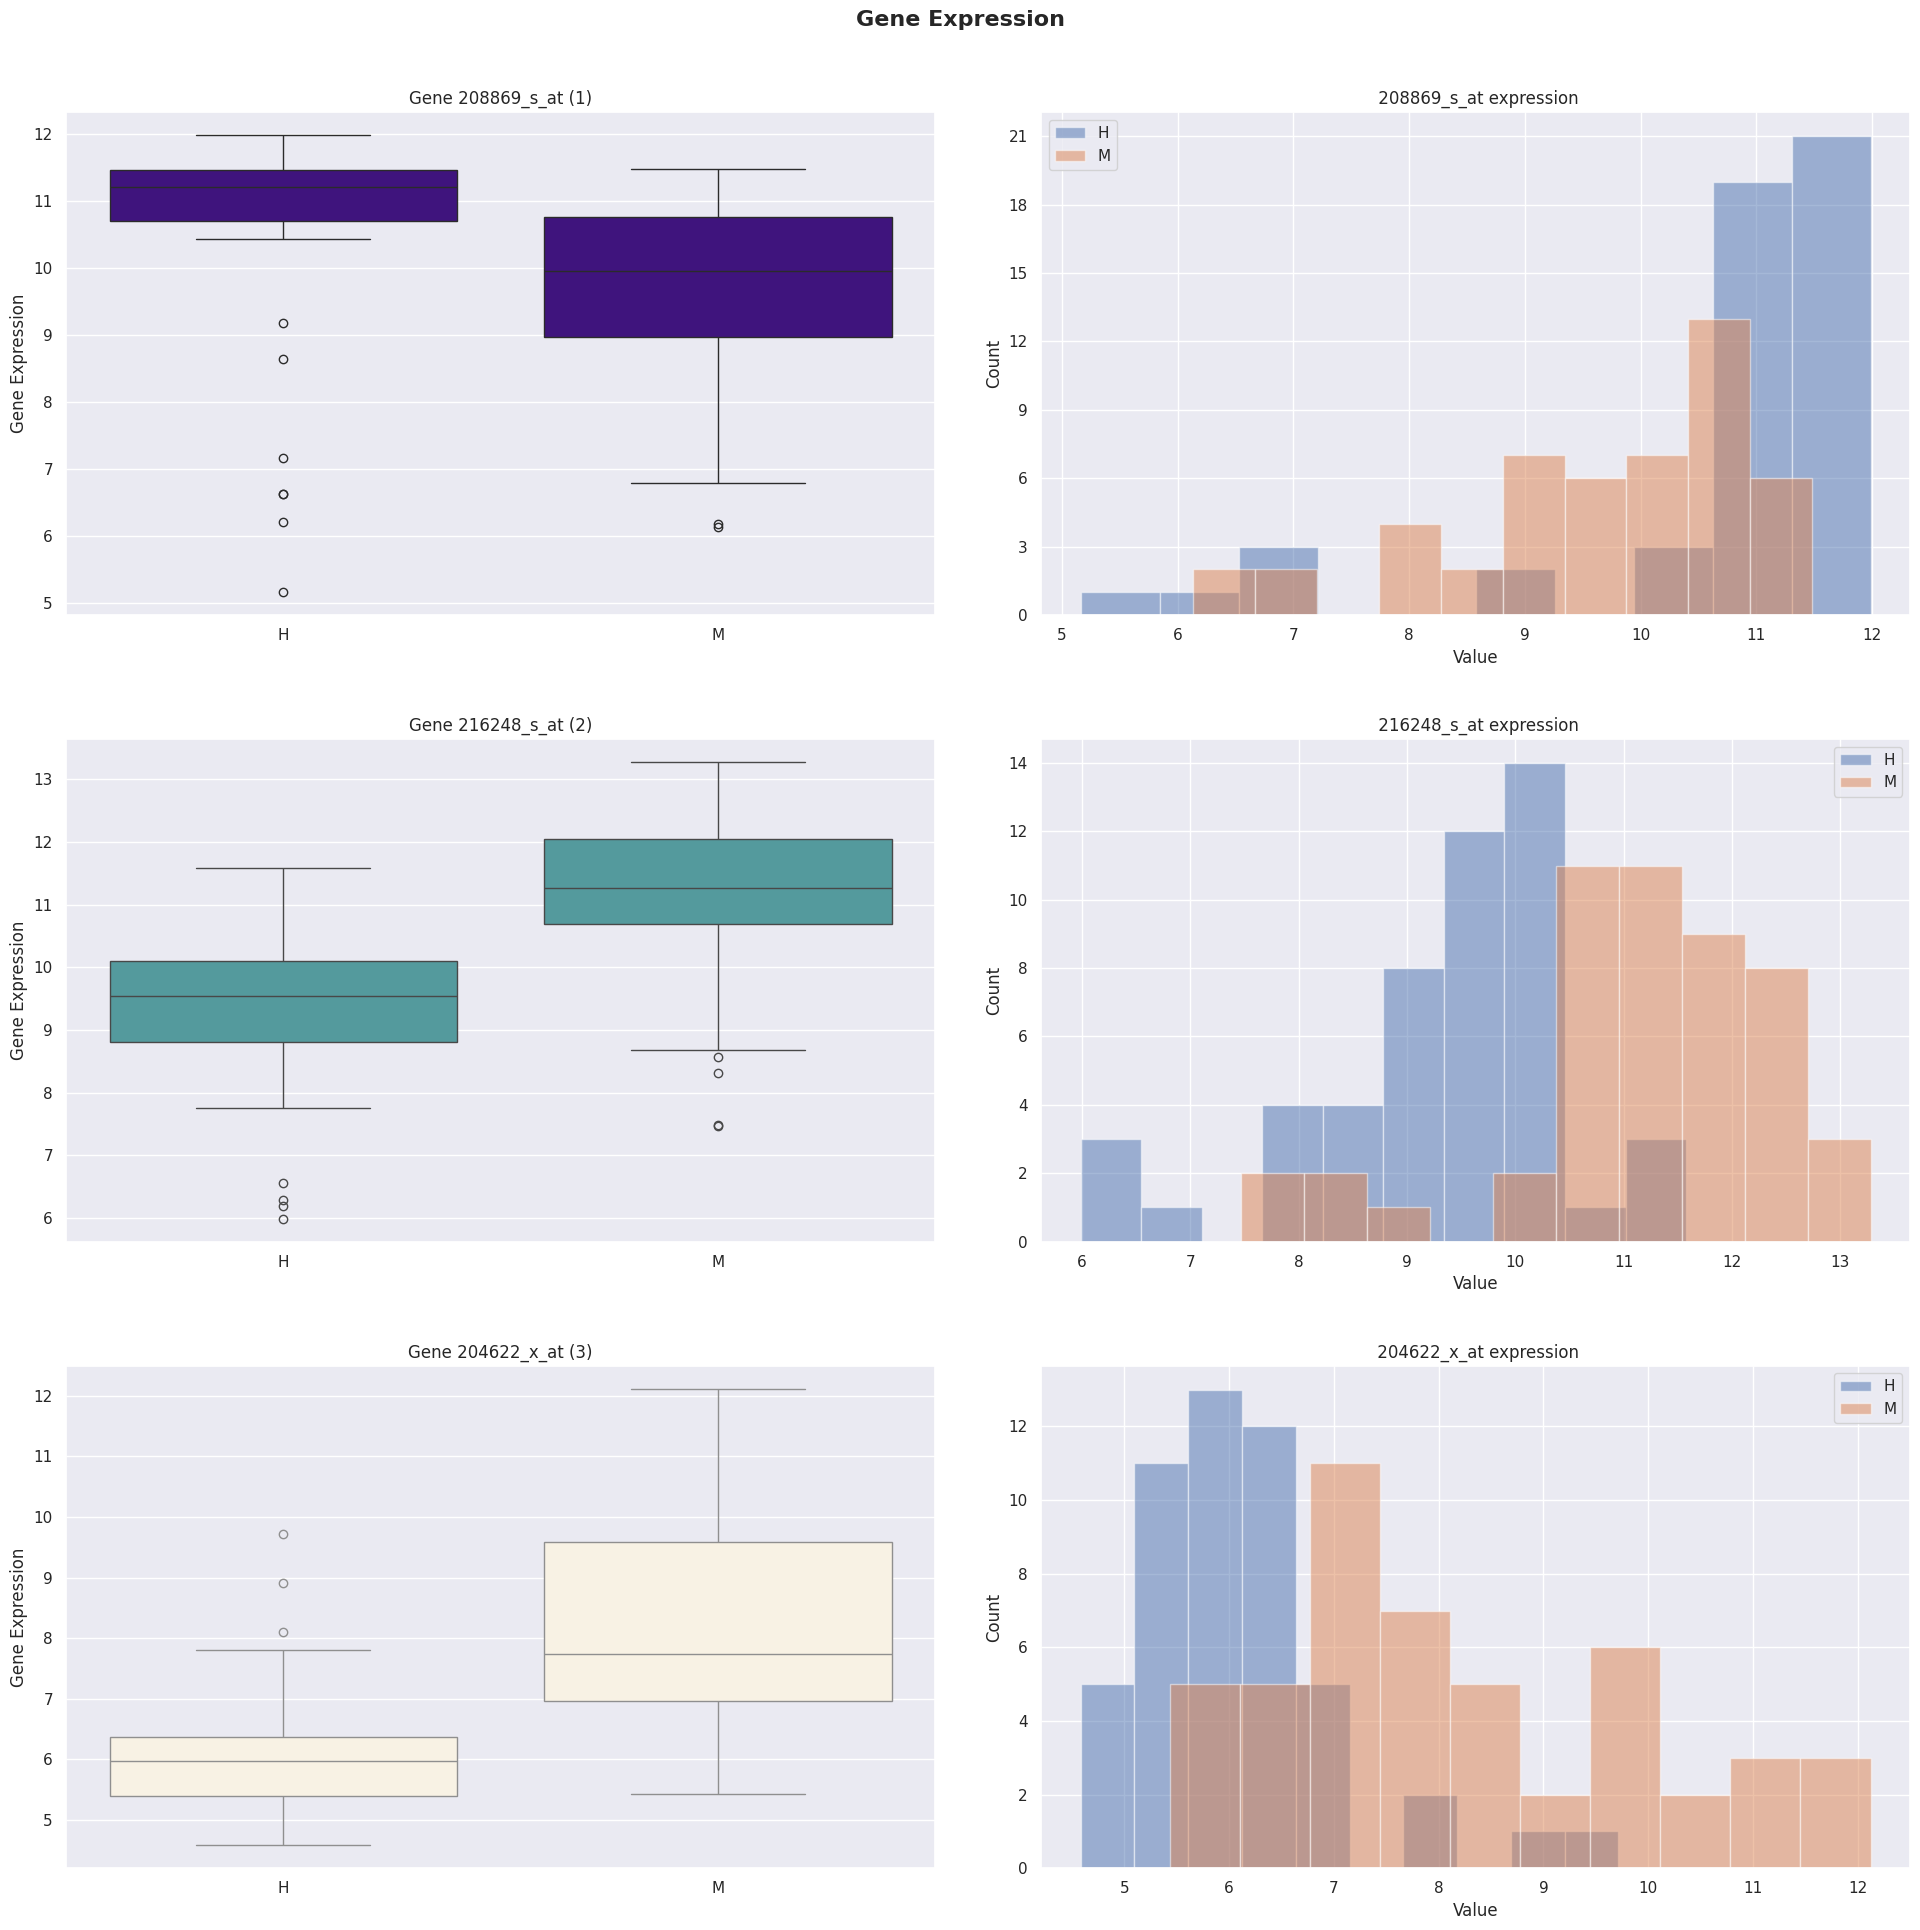

In [90]:
plot_3_exression_patterns(D)

**3.e.4**

Heatmap Draw a heatmap representation of the expression values of the genes in D (from 3d), across the entire cohort (all samples). Order the genes and the samples to produce the maximal visual effect.

In [91]:
def plot_heat_map(D):
  D = D.drop("Class", axis=1)
  D = D.astype(float)
  sorted_df = D.mean().sort_values().index
  df_sorted = D[sorted_df]
  plt.figure(figsize=(20, 10))
  plt.imshow(df_sorted, cmap="CMRmap_r", interpolation="nearest", aspect="auto")
  plt.colorbar()
  plt.title("D Heatmap With Maximal Visual Effect")
  plt.show()

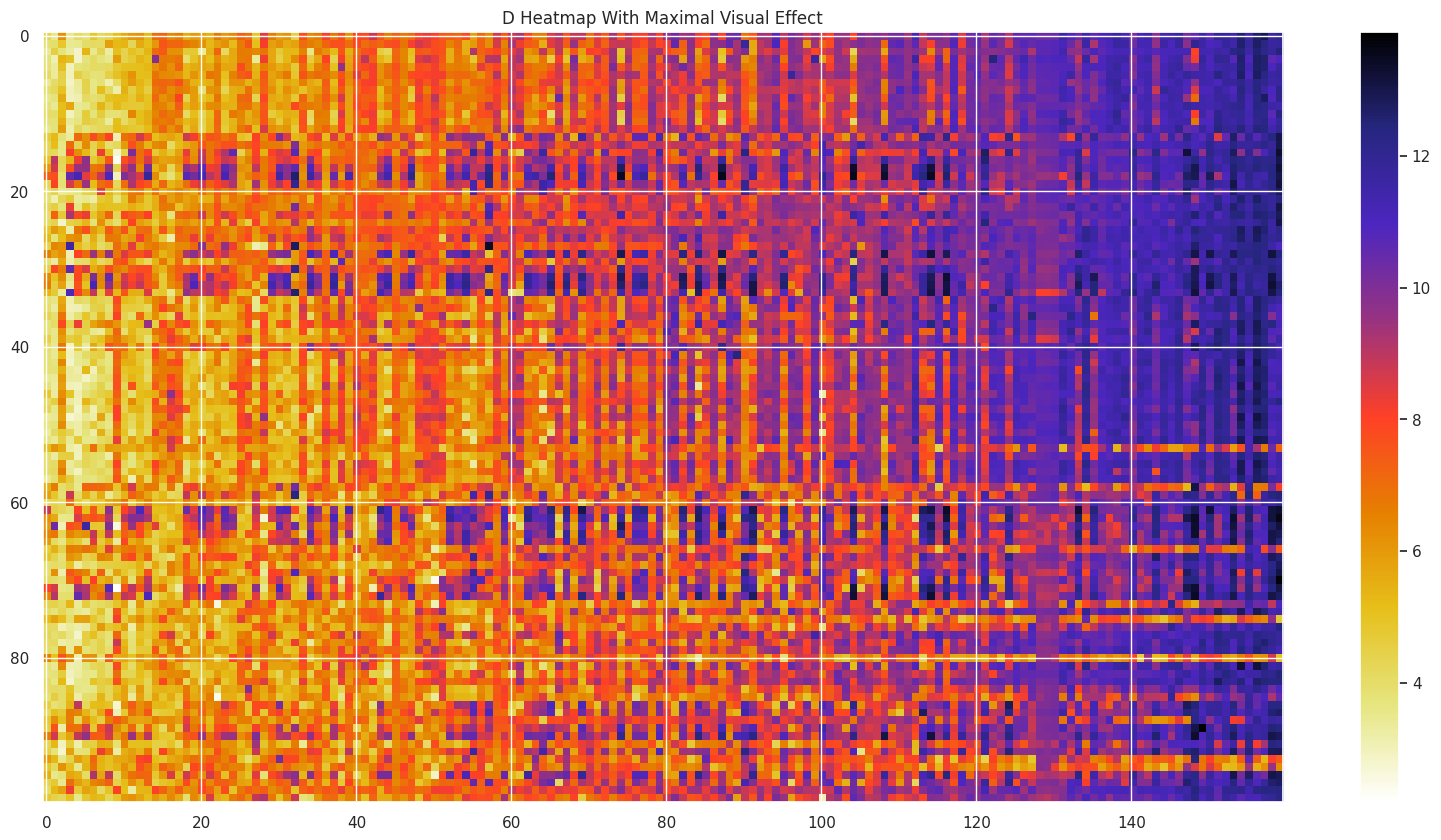

In [92]:
plot_heat_map(D)